In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed as set_seed, randint
from scipy import stats
from jax.interpreters.xla import DeviceArray
from jax import grad, jit

DeviceArray.abs = np.abs
DeviceArray.pipe = lambda self, func: func(self)

plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'Dark2'

# Definitions

In [11]:
def classify(X, B, c):
    tiles = (X[:, :, np.newaxis] > B[np.newaxis, :, :]).sum(axis=2)
    tiles_flat = tiles @ np.array([(k+1)**i for i in range(d)])
    return c[tiles_flat]

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def make_normal_unit_vector(d):
    v = np.append(-1, np.ones(d-1))
    return v/np.sqrt(v@v)

def generate_data(N, d, sep=0, dist=stats.norm()):
    X = dist.rvs(size=(N, d))
    w = make_normal_unit_vector(d)
    y = np.sign(X @ w)
    X += sep*y[:, np.newaxis]*w
    return X, y

def generate_random_boundaries(X, d, k):
    dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
    sample = lambda: np.array(dist.rvs(size=(1, k))).sort()
    return np.concatenate([sample() for _ in range(d)])

def plot_2d_problem(X, y, B):
    x = np.linspace(X.min(), X.max(), 100)
    plt.scatter(*X.T, c=y, alpha=0.25)
    plt.plot(x, x, 'k--', alpha=0.15)
    plt.vlines(B[0], X.min(), X.max(), colors='k', linestyles='dashed')
    plt.hlines(B[1], X.min(), X.max(), colors='k', linestyles='dashed')

In [18]:
N: 'sample size' = 2_000
d: 'problem dimension' = 2
R: 'bit rate per dimension' = 2
S: 'sample (N, d) (N,)' = generate_data(N, d, sep=0.25, dist=stats.norm())
X, y = S
w: 'unit vector normal to class. boundary (d,)' = make_normal_unit_vector(d)
k: 'number of boundaries (roots) per dimension' = 2**R - 1
B: 'boundaries matrix (d, k)' = generate_random_boundaries(X, d, k)
c: 'label of each tile (2**(R*d),)' = np.array(2*randint(2, size=2**(R*d))-1).astype('float32')
    
seed: 'global numpy seed' = None
set_seed(seed)

# 2D Problem

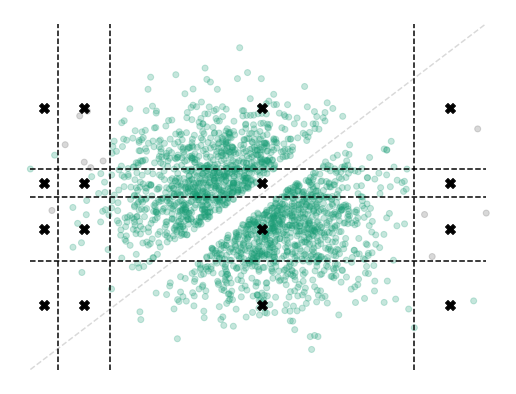

In [19]:
plt.figure(figsize=(9, 7))
plot_2d_problem(X, classify(X, B, c), B)
B_ = np.hstack([X.min(axis=0)[:, np.newaxis],
                B,
                X.max(axis=0)[:, np.newaxis]])
RX = (B_[:, :-1] + B_[:, 1:])/2
RX = np.stack(np.meshgrid(*RX), axis=-1).reshape(-1, d)
plt.scatter(*RX.T, s=100, marker='X', c='black')
plt.axis('off');

# Distance to closest boundary

In [5]:
def min_distance_model(θ, X):
    B, c = θ
    p = np.abs(X[:, :, np.newaxis] - B[np.newaxis, :, :])
    return sigmoid(p.min(axis=2).min(axis=1))

min_distance_model([B,c], X)

DeviceArray([0.52645427, 0.63675946, 0.63426965, ..., 0.55004525,
             0.5755885 , 0.60877234], dtype=float32)